In [1]:
import sys
sys.path.append('/home/yat-lok/workspace/tvbtools/')
# sys.path.append('/mnt/w/github/tvbtools/')
from tools.signaltools import SignalToolkit
from tools.pathconverter import prefix_path
pth = prefix_path()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
my_layout = widgets.Layout()
plt.style.use('ggplot')
import os

In [2]:
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMp-R','mTEMp-L','mTEMp-R']
fs = 81920.0
samplinginterval = 1/fs
t = np.arange(0, 1, samplinginterval)
grps = ['SNC','NC','MCI','AD']
col = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
# path = '/mnt/w/Gc_Go.xlsx'
path = '/mnt/c/Users/Wayne/tvb/stat_data/Gc_Go.xlsx'
coData = pd.read_excel(path)

def read_data(grp, caseid, amp='p2v'):
    gm = np.round(coData.loc[coData['caseid'] == caseid, 'Gc'].item(), 3)
    filename = '/mnt/d/data/LFP/'+str(grp)+'/'+str(caseid)+'/'+str(caseid)+'_'+str(gm)+'.csv'
    # filename = '/mnt/w/gc3mins/'+grp+'/'+caseid+'.h5'
    subject = SignalToolkit(filename, 81920.)
    df = subject.data_reader()

    cutoff_low = 2.
    cutoff_high = 10.
    spikesparas = {'prominence': 1.0}
    valleysparas= {'prominence': 0.2, 'width':2000, 'height': -0.5}
    spikesparas_af= {'prominence': 0.3, 'width':2000, 'height': 0.}
    valleysparas_af = {'prominence': 0.2, 'width':2000, 'height': -0.5}

    pcgl=subject.signal_package(data=df, channel_num = 4, label='pcg_left', low=cutoff_low, high=cutoff_high, spikesparas=spikesparas, valleysparas=valleysparas, spikesparas_af=spikesparas_af, valleysparas_af = valleysparas, truncate=0)
    pcgr=subject.signal_package(data=df, channel_num = 5, label='pcg_right', low=cutoff_low, high=cutoff_high, spikesparas=spikesparas, valleysparas=valleysparas, spikesparas_af=spikesparas_af, valleysparas_af=valleysparas_af, truncate=0)

    # # visualization
    # fig = plt.figure(figsize=(15,5))
    # axes = fig.add_subplot(111)
    # axes.set_title(f"{grp}_{caseid}")
    # subject.signal_af(**pcgl, axes=axes)
    # subject.signal_af(**pcgr, axes=axes)
    # plt.legend()
    # plt.savefig(f"/mnt/c/Users/Wayne/tvb/gc1sec_res/{grp}/{caseid}.png", dpi = 300)

    # freq
    pcgl_freq_gamma = subject.freq_count(pcgl["spikeslist"])
    pcgr_freq_gamma = subject.freq_count(pcgr["spikeslist"])
    pcgl_freq_theta = subject.freq_count(pcgl["spikeslist_af"])
    pcgr_freq_theta = subject.freq_count(pcgr["spikeslist_af"])

    # amp
    if amp in ['p2v']:
        pcgl_amp_gamma = subject.amp_count(**pcgl, mode="p2v")
        pcgr_amp_gamma = subject.amp_count(**pcgr, mode="p2v")
        pcgl_amp_theta = subject.amp_count(data=pcgl["after_filtered"], spikeslist=pcgl["spikeslist_af"], valleyslist=pcgl["valleyslist_af"], mode="p2v")
        pcgr_amp_theta = subject.amp_count(data=pcgr["after_filtered"], spikeslist=pcgr["spikeslist_af"], valleyslist=pcgr["valleyslist_af"], mode="p2v")
    elif amp in ['ap']:
        # another version of amp
        pcgl_amp_gamma, pcgl_amp_theta = subject.amp_count(**pcgl, mode="ap")
        pcgr_amp_gamma, pcgr_amp_theta = subject.amp_count(**pcgr, mode="ap")


    # delay
    pcg_delay = subject.phase_delay(pcgl["after_filtered"], pcgr["after_filtered"], pcgl["spikeslist_af"], pcgl["valleyslist_af"], pcgr["spikeslist_af"], pcgr["valleyslist_af"], mode = "SI")

    res_dict = {"group":grp, 
    "caseid":caseid, 
    "pcgl_freq_gamma":pcgl_freq_gamma,
    "pcgr_freq_gamma":pcgr_freq_gamma,
    "pcgl_freq_theta":pcgl_freq_theta,
    "pcgr_freq_theta":pcgr_freq_theta,
    "pcgl_amp_gamma":pcgl_amp_gamma,
    "pcgr_amp_gamma":pcgr_amp_gamma,
    "pcgl_amp_theta":pcgl_amp_theta,
    "pcgr_amp_theta":pcgr_amp_theta,
    "pcg_delay":pcg_delay}
    return res_dict

    # fig = plt.figure(figsize=(15,5))
    # axes = fig.add_subplot(111)
    # for i in range(16):
    #     _, power = subject.psd(df[:,i], sampling_interval = 1/fs, visual=True, xlim=100., axes=axes, label=f"{node_names[i]}")
    #     if i == 4:
    #         highest_pcg_left = np.argmax(power)
    #     if i == 5:
    #         highest_pcg_right = np.argmax(power)
    # axes.set_title(f"{grp}_{caseid}")
    # plt.savefig(f"/mnt/c/Users/wayne/tvb/psdres/{grp}_{caseid}.png", dpi=300)
    # return highest_pcg_left, highest_pcg_right

In [3]:
#read_data('AD', "2050A")

In [4]:
# # grab overall results
dfa = pd.DataFrame()
for grp, caseid in zip(coData.groups, coData.caseid):
    res_dict = read_data(grp, caseid)
    dfa = pd.concat([dfa, pd.DataFrame.from_dict([res_dict])], ignore_index=True)
dfa.to_excel('/mnt/c/Users/Wayne/tvb/gc1sec_res/gc1sec_res.xlsx')

In [5]:
# grab lateralization results

#%matplotlib widget
# print(coData)
# read_data('MCI', "2050A")
df = pd.DataFrame()
laname = ['freq_gamma', 'freq_theta', 'amp_gamma', 'amp_theta']
la_dict = {}
for grp, caseid in zip(coData.groups, coData.caseid):
    res_dict = read_data(grp, caseid)
    _pre_la = [res_dict.get(n) for n in res_dict.keys()][2:]
    la_dict['group'] = grp
    la_dict['caseid'] = caseid
    for ind, n in enumerate(range(0, int(len(_pre_la)-1), 2)):
        _la = SignalToolkit.lateral(_pre_la[n], _pre_la[n+1])
        la_dict[laname[ind]] = _la
        _df = pd.DataFrame.from_dict([la_dict])
    df = pd.concat([df, _df], ignore_index=True)


df.to_excel('/mnt/c/Users/Wayne/tvb/gc1sec_res/lateralization.xlsx')


In [6]:
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]

import seaborn as sns
def psvplot(x,y, df, colors=None, axes=None):
    sns.violinplot(x=x, y=y, data=df, palette=colors, inner = None, width=0.7, bw=0.2, ax=axes)
    sns.stripplot( data=df, x=x, y=y, color='black', label="right", ax = axes)
    sns.pointplot(x=x, y=y, data=df, estimator=np.mean, color = 'red', ax=axes)

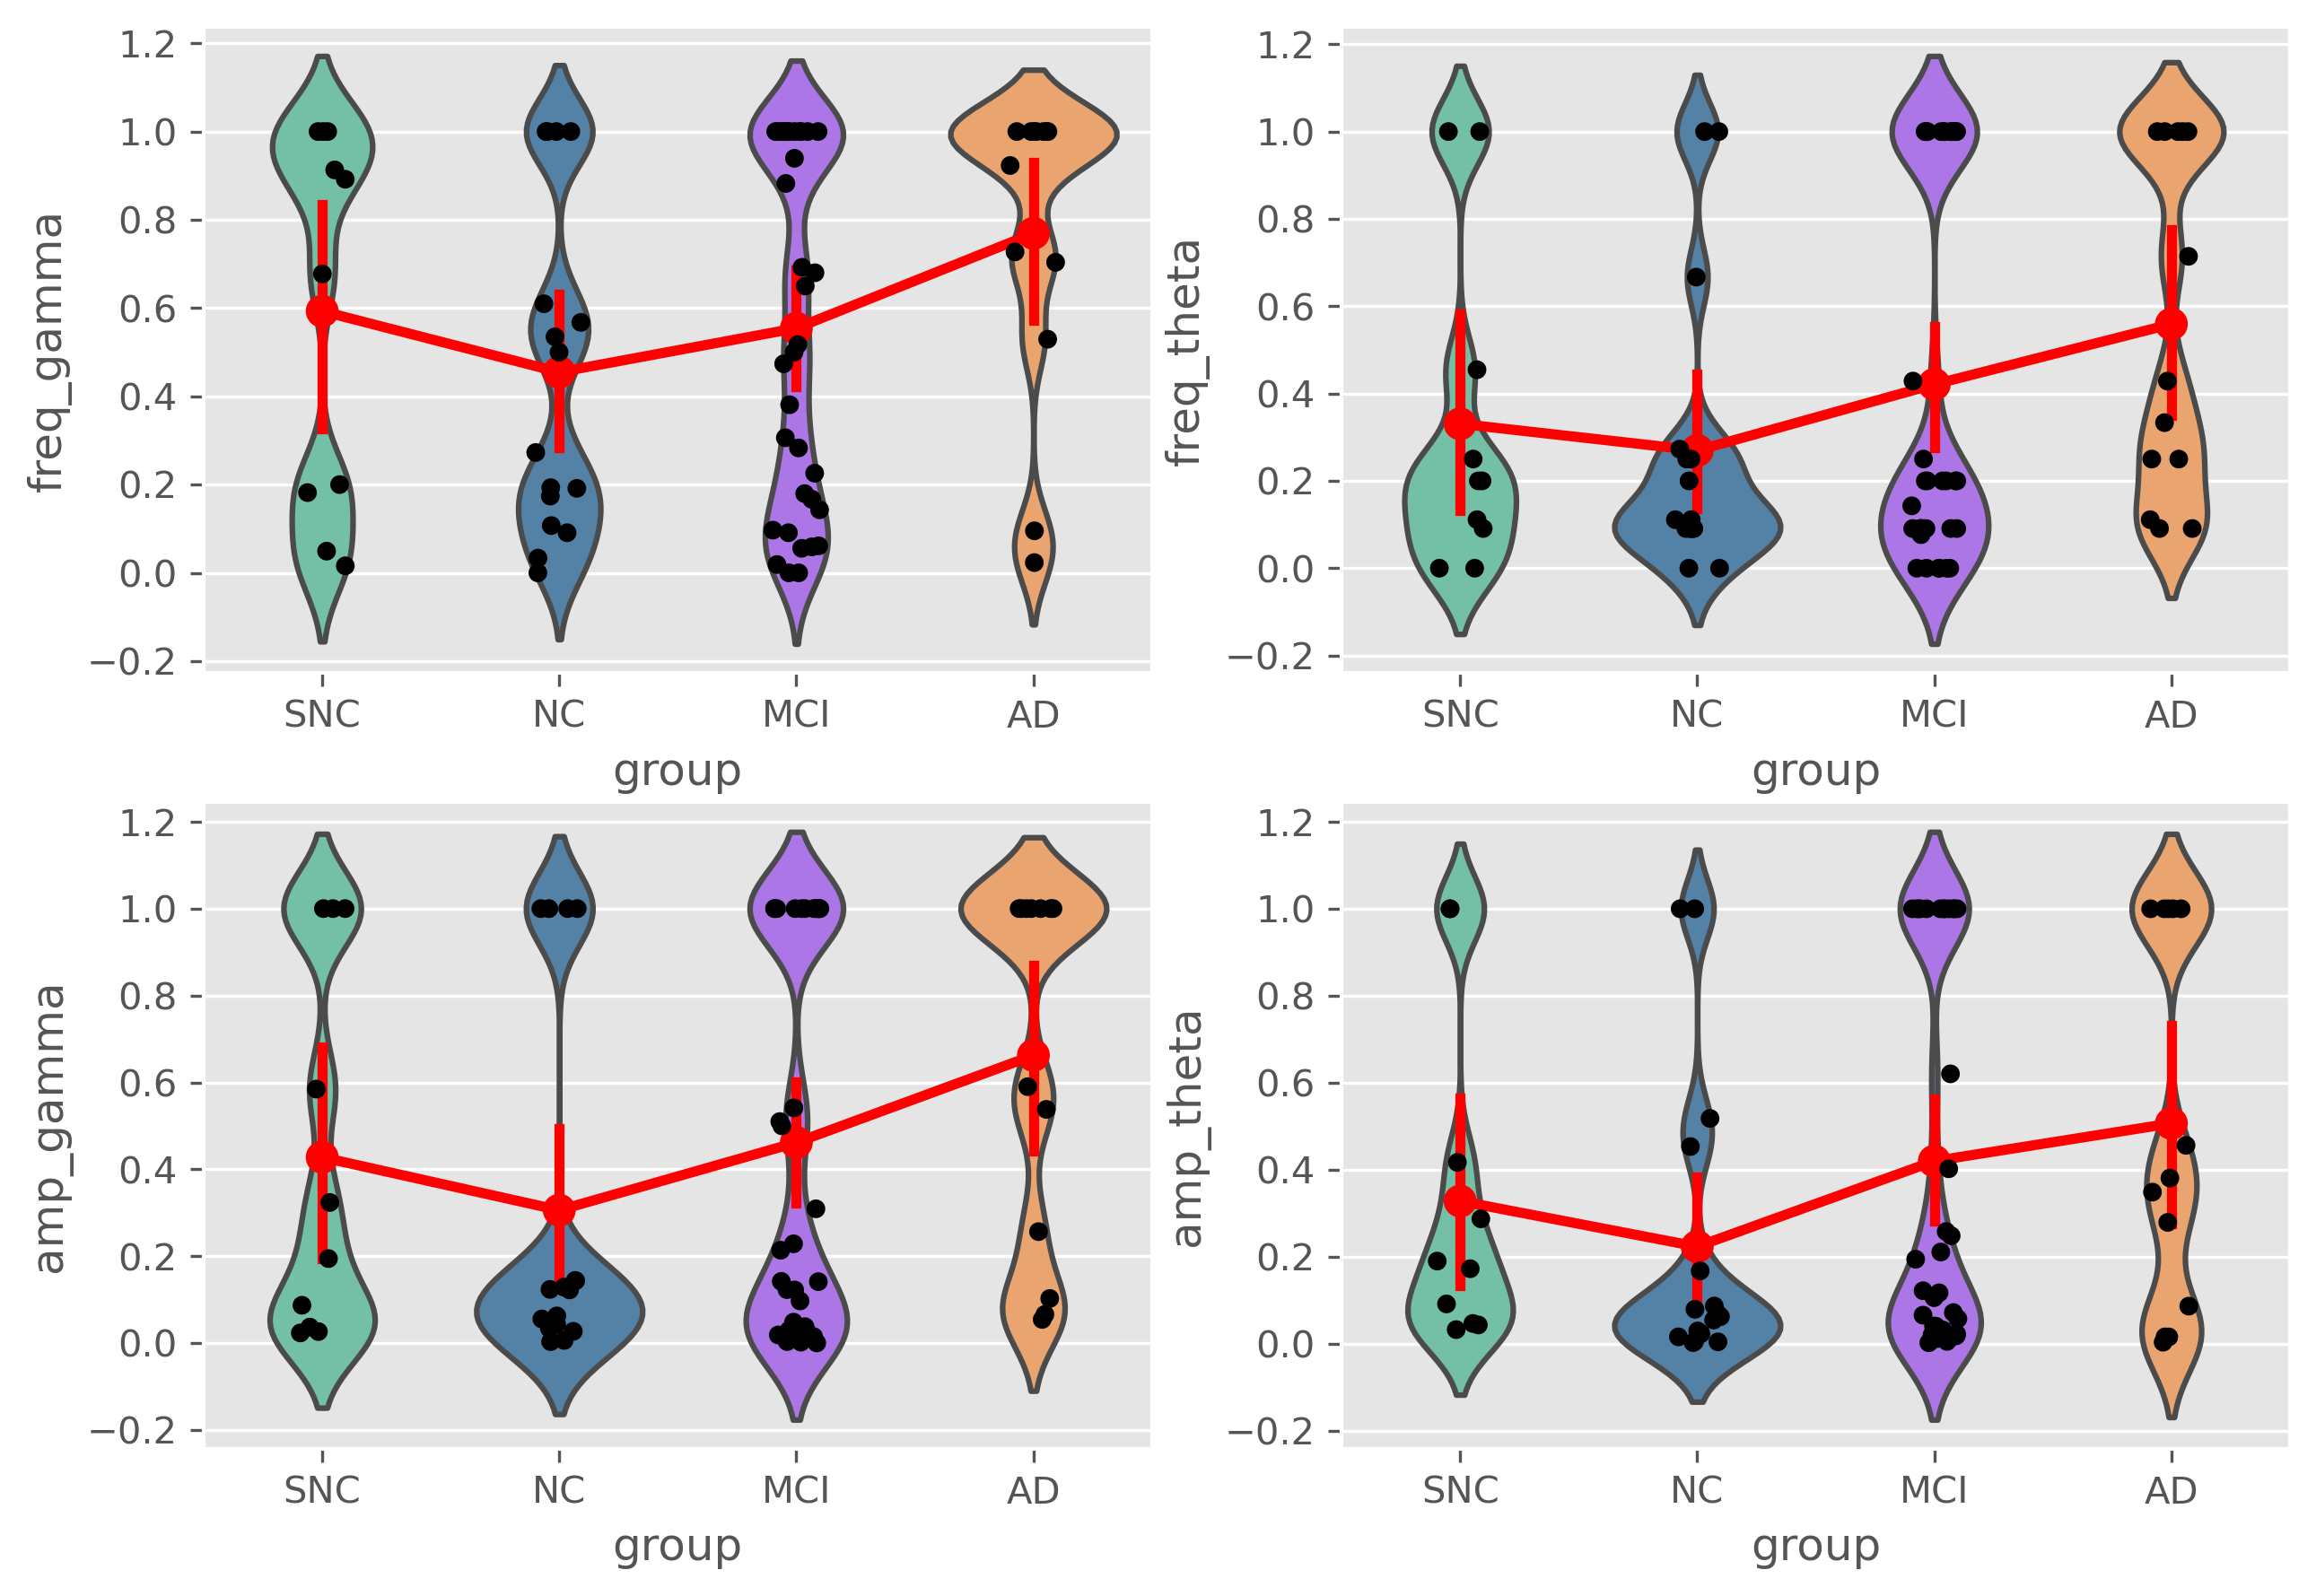

In [7]:
# a = 431
# fig = plt.figure(figsize=(15,20))
# for ind, n in enumerate(range(2, len(dfa.columns))):
#     axes = fig.add_subplot(a+ind)
#     psvplot('grp',dfa.columns[n], df=dfa, colors=colors, axes=axes)

a=221
fig = plt.figure(figsize=(10,7), dpi=300)
for ind, n in enumerate(range(4)):
    axes = fig.add_subplot(a+ind)
    psvplot('group',laname[n], df, colors=colors, axes=axes)


In [8]:
import sys
sys.path.append("/home/yat-lok/workspace/tvbtools")
from tools.statools import stats_calculator
import pandas as pd
ddf = pd.read_excel('/mnt/c/Users/Wayne/tvb/gc1sec_res/lateralization.xlsx')

daf = stats_calculator(ddf, mode="P")

daf.to_excel('/mnt/c/Users/Wayne/tvb/gc1sec_res/lateral_stats.xlsx')

/home/yat-lok/miniconda3/envs/tvbenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yat-lok/miniconda3/envs/tvbenv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


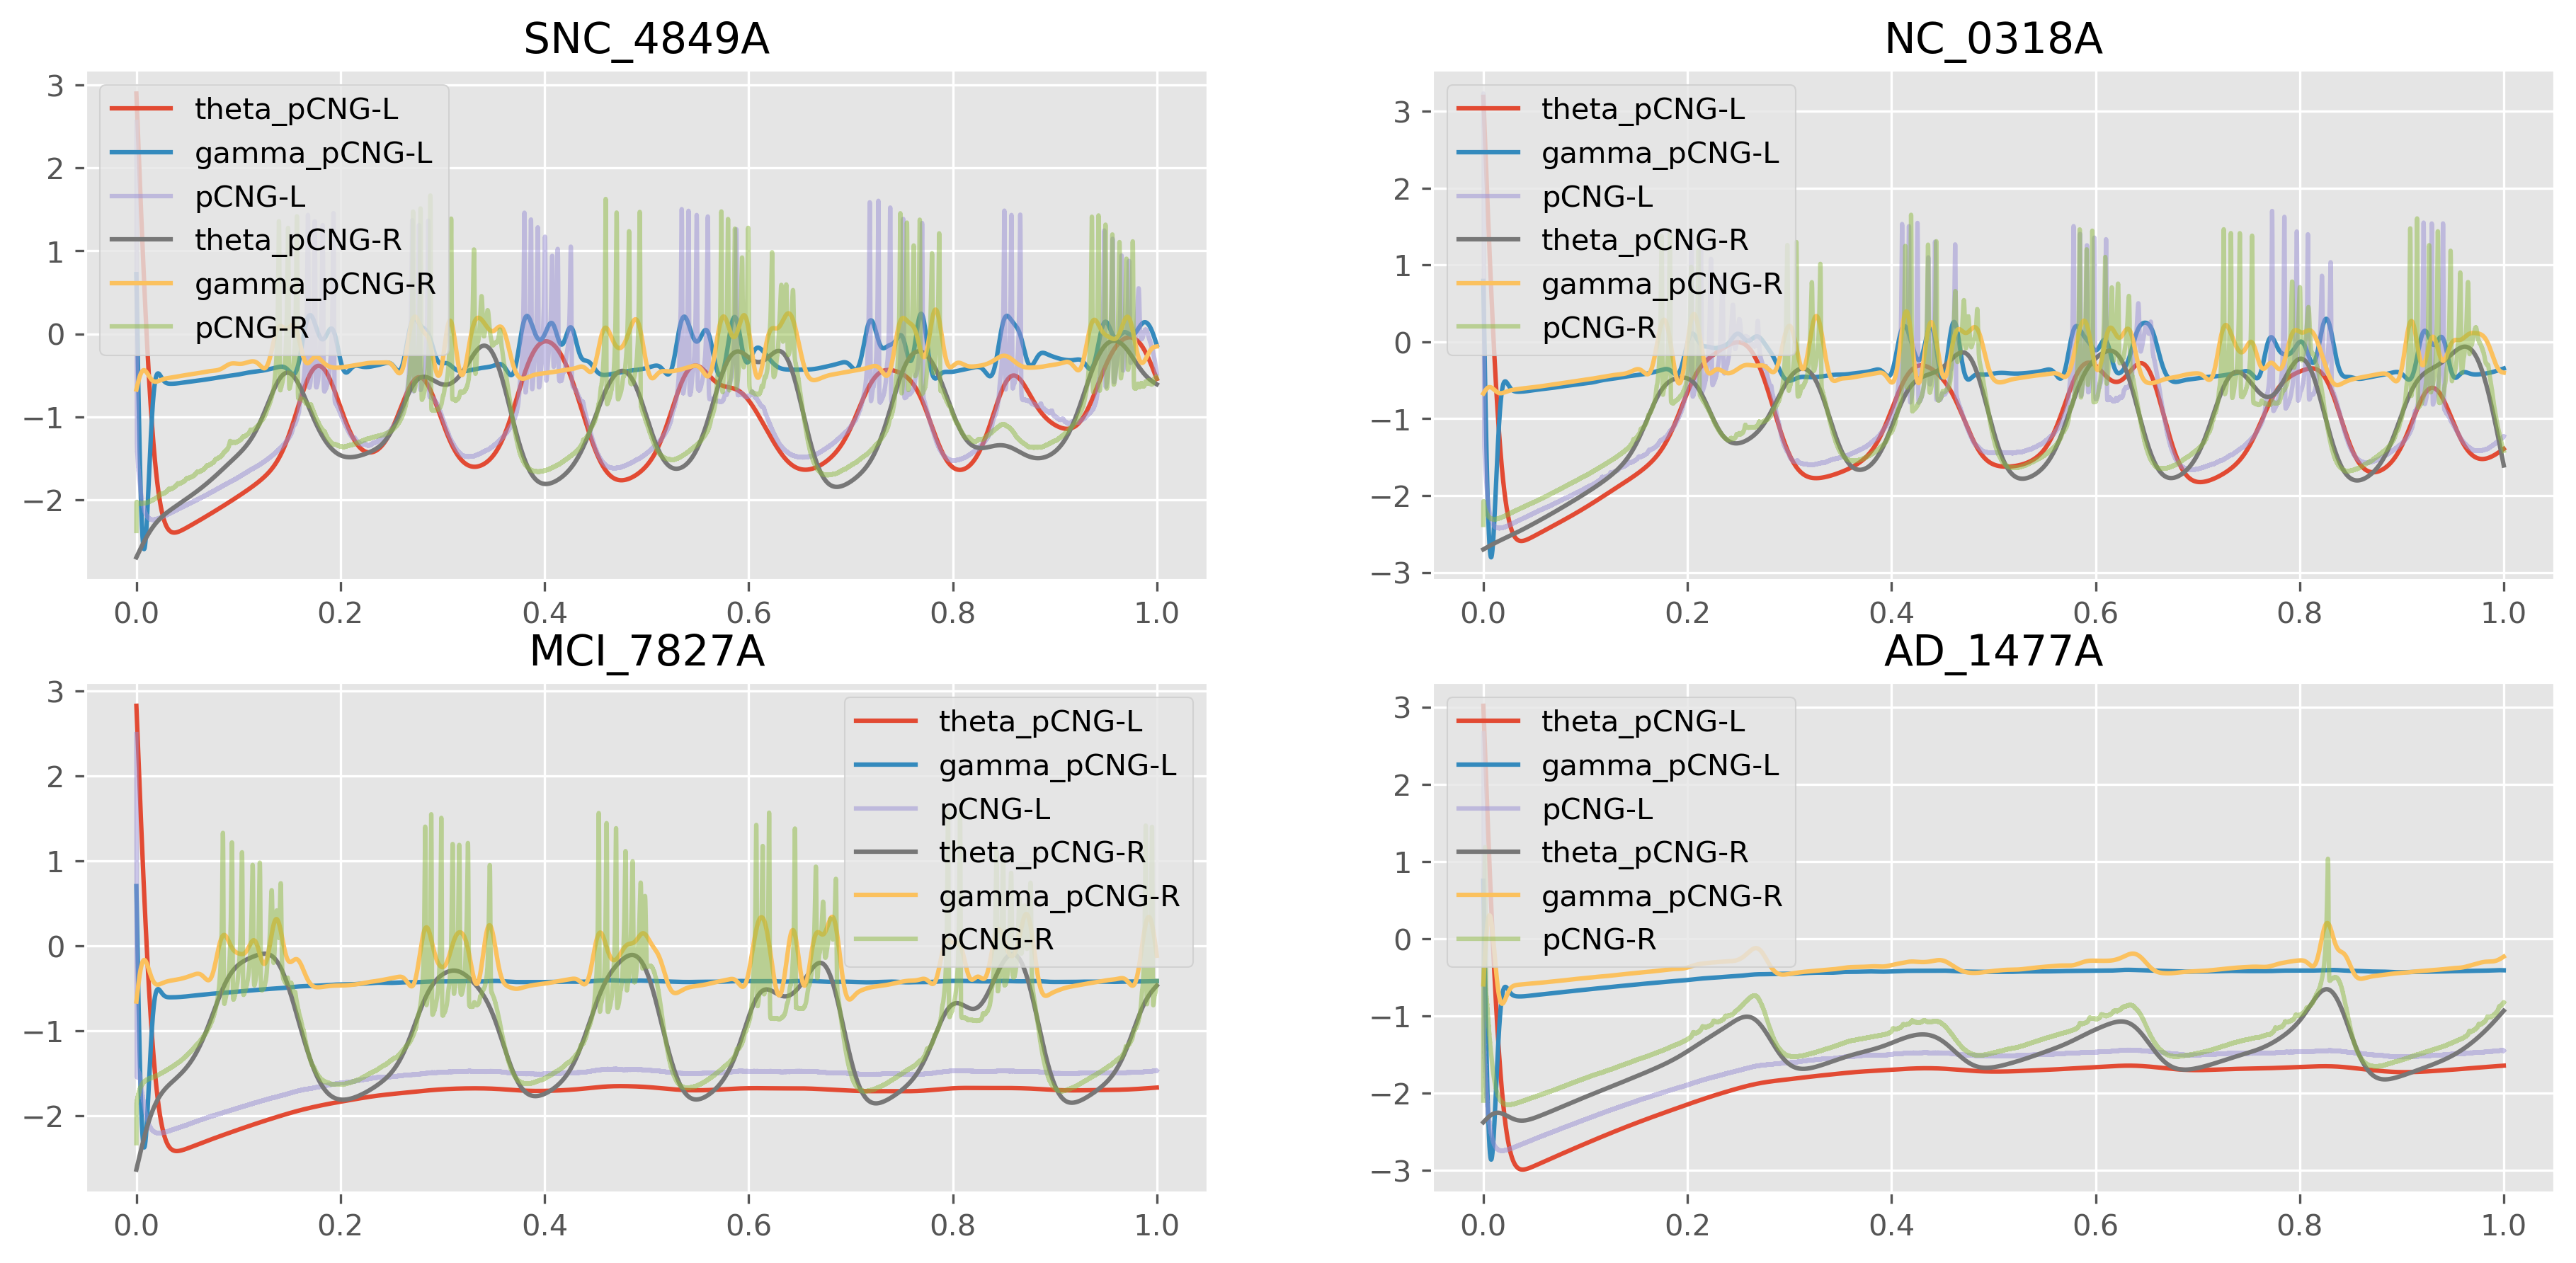

In [10]:
import sys
sys.path.append("/home/yat-lok/workspace/tvbtools")
from tools.signaltools import SignalToolkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
plt.style.use('ggplot')
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R']



def essay_res1(caseid, grp, key, fig):
    path = '/mnt/c/Users/Wayne/tvb/stat_data/Gc_Go.xlsx'
    coData = pd.read_excel(path)
    gm = np.round(coData.loc[coData['caseid'] == caseid, 'Gc'].item(), 3)
    filename = '/mnt/d/data/LFP/'+str(grp)+'/'+str(caseid)+'/'+str(caseid)+'_'+str(gm)+'.csv'
    # filename = '/mnt/w/gc3mins/'+grp+'/'+caseid+'.h5'
    df = pd.read_csv(filename)
    
    axes = fig.add_subplot(key)
    axes.set_title(f"{grp}_{caseid}")
    for i in range(16):
        Wn = [2,10]
        fNQ = 81920/2
        n=2048
        b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
        Vlo = signal.filtfilt(b, 1, df.loc[:,node_names[i]]);   # ... and apply it to the data.
        # b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
        # Vhi = signal.filtfilt(b, 1, df.loc[:,node_names[i]]);   # ... and apply it to the data.
        Vlo = SignalToolkit.hamming_filter(data = df.loc[:,node_names[i]], n=4096)
        Vhi = SignalToolkit.hamming_filter(data=df.loc[:,node_names[i]], Wn = [10, 60], n=4096)
        # phi = signal.angle(signal.hilbert(Vlo))  # Compute phase of low-freq signal
        # amp = abs(signal.hilbert(Vhi))       # Compute amplitude of high-freq signal
        if node_names[i] in ['pCNG-L', 'pCNG-R']:
            axes.plot(np.arange(0,1,1/81920), Vlo, label=f"theta_{node_names[i]}")
            axes.plot(np.arange(0,1,1/81920), Vhi, label=f"gamma_{node_names[i]}")
            axes.plot(np.arange(0,1,1/81920), df.loc[:,node_names[i]], label=node_names[i], alpha=0.5)
        # else:
        #     axes.plot(np.arange(0,1,1/81920),df.loc[:,node_names[i]])
    plt.legend()


caseids = ["4849A", "0318A", "7827A", "1477A"]
grps= ['SNC','NC','MCI','AD']
keynum = [221,222,223,224]

fig = plt.figure(figsize=(15,7), dpi=300)
for casid, grp, key in zip(caseids, grps, keynum):
    essay_res1(casid, grp, key, fig)


In [ ]:
from scipy.stats import ranksums
rng = np.random.default_rng()
sample1 = rng.uniform(-1, 1, 200)
sample2 = rng.uniform(-0.5, 1.5, 300) # a shifted distribution
_, pvalue = ranksums(sample1, sample2)
print(pvalue)